In [1]:
import sys
sys.path.append("../src")

In [38]:
from collections import defaultdict
import gzip
import itertools
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import subprocess
from typing import Iterable, Union

In [3]:
def qiime(*args: Union[str, Path]):
    return subprocess.check_output(["/opt/conda/envs/qiime2-2022.8/bin/qiime", *args])

## Find the Data Files

In [8]:
train_path = Path("/home/dwl2x/work/qiime-classifier")
train_path.mkdir(exist_ok=True)

In [9]:
fasta_files = [Path("/home/dwl2x/work/Datasets/Silva/Silva_138.1.fasta")]
fasta_files

[PosixPath('/home/dwl2x/work/Datasets/Silva/Silva_138.1.fasta')]

In [10]:
taxonomy_files = [Path("/home/dwl2x/work/Datasets/Silva/Silva_138.1.tax.tsv")]
taxonomy_files

[PosixPath('/home/dwl2x/work/Datasets/Silva/Silva_138.1.tax.tsv')]

## Create the Qiime Artifacts

### Sequences Artifact

In [15]:
fasta_file = fasta_files[0]
sequences_artifact = train_path / "0.sequences.qza"

In [16]:
qiime("tools", "import",
      "--input-path", fasta_file,
      "--output-path", sequences_artifact,
      "--type", "FeatureData[Sequence]"
)

b'Imported /home/dwl2x/work/Datasets/Silva/Silva_138.1.fasta as DNASequencesDirectoryFormat to /home/dwl2x/work/qiime-classifier/0.sequences.qza\n'

### Taxonomy Artifact

In [17]:
taxonomy_file = taxonomy_files[0]
taxonomy_artifact = train_path / "0.taxonomy.qza"

In [18]:
qiime("tools", "import",
    "--input-path", taxonomy_file,
    "--output-path", taxonomy_artifact,
    "--input-format", "HeaderlessTSVTaxonomyFormat",
    "--type", "FeatureData[Taxonomy]"
)

b'Imported /home/dwl2x/work/Datasets/Silva/Silva_138.1.tax.tsv as HeaderlessTSVTaxonomyFormat to /home/dwl2x/work/qiime-classifier/0.taxonomy.qza\n'

In [ ]:
qiime("feature-classifier", "fit-classifier-naive-bayes",
    "--i-reference-reads", train_path / "0.sequences.qza",
    "--i-reference-taxonomy", train_path / "0.taxonomy.qza",
    "--o-classifier", train_path / "classifier.qza"
)

In [27]:
qiime("tools", "export",
    "--input-path", train_path / "classifier.qza",
    "--output-path", train_path / "classifier"
)

b'Exported /home/dwl2x/work/qiime-classifier/classifier.qza as TaxonomicClassiferTemporaryPickleDirFmt to directory /home/dwl2x/work/qiime-classifier/classifier\n'

In [1]:
!qiime tools export \
    --input-path /tmp/qiime-artifacts/classifier.qza \
    --output-path /tmp/qiime-artifacts/classifier

Exported /tmp/qiime-artifacts/classifier.qza as TaxonomicClassiferTemporaryPickleDirFmt to directory /tmp/qiime-artifactsclassifier


In [193]:
len(BASES + INCOMPLETE_BASES)

15

---

In [4]:
# from deepdna.data import dataset
from tqdm.contrib.concurrent import process_map
from tqdm.auto import tqdm
import time

### Load Model

In [16]:
def find_fastas_and_taxonomies(path: str):
    path = Path(path)
    fastas = []
    taxas = []
    for f in path.iterdir():
        if str(f).endswith(".fasta"):
            fastas.append(f)
        elif str(f).endswith(".tax.tsv"):
            taxas.append(f)
    fastas.sort()
    taxas.sort()
    return list(zip(fastas, taxas))

In [6]:
def read_fasta_and_taxonomies(fasta_path, tax_path):
    fasta_file = open(fasta_path)
    tax_file = open(tax_path)
    tax_map = {}
    for line in tax_file:
        identifier, label = line.strip().split('\t')
        tax_map[identifier] = label
    sequences = []
    labels = []
    header = fasta_file.readline().strip()
    while header:
        identifier = header[1:].split(' ')[0]
        sequence = fasta_file.readline().strip()
        sequences.append(sequence)
        labels.append(tax_map[identifier])
        header = fasta_file.readline().strip()
    fasta_file.close()
    tax_file.close()
    return sequences, labels

In [11]:
# Extract the tar first...
model = joblib.load(os.path.join(train_path, "classifier/sklearn_pipeline.pkl"))

In [55]:
model_type = "Topdown"

In [57]:
datasets = {
    "Nachusa": find_fastas_and_taxonomies(f"/home/dwl2x/work/Datasets/Synthetic/Nachusa/{model_type}/test"),
    "Hopland": find_fastas_and_taxonomies(f"/home/dwl2x/work/Datasets/Synthetic/Hopland/{model_type}/test"),
    "Wetland": find_fastas_and_taxonomies(f"/home/dwl2x/work/Datasets/Synthetic/Wetland/{model_type}/test"),
    "SFD": find_fastas_and_taxonomies(f"/home/dwl2x/work/Datasets/Synthetic/SFD/{model_type}/test"),
}

In [58]:
def run(args):
    fasta_file, tax_file = args
    sequences, labels = read_fasta_and_taxonomies(fasta_file, tax_file)
    pred = model.predict(sequences)
    return np.sum(pred == labels) / len(labels)
dataset_accuracies = {}
for dataset_name, files in datasets.items():
    t = time.time()
    print(dataset_name)
    accuracies = process_map(run, files, max_workers=48)
    accuracies = np.array(accuracies)
    print(time.time() - t)
    dataset_accuracies[dataset_name] = accuracies

Nachusa


/tmp/ipykernel_641648/2077366298.py:10: TqdmWarning: Iterable length 2100 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  accuracies = process_map(run, files, max_workers=48)


  0%|          | 0/2100 [00:00<?, ?it/s]

707.9109873771667
Hopland


/tmp/ipykernel_641648/2077366298.py:10: TqdmWarning: Iterable length 1280 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  accuracies = process_map(run, files, max_workers=48)


  0%|          | 0/1280 [00:00<?, ?it/s]

426.6026928424835
Wetland


/tmp/ipykernel_641648/2077366298.py:10: TqdmWarning: Iterable length 7680 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  accuracies = process_map(run, files, max_workers=48)


  0%|          | 0/7680 [00:00<?, ?it/s]

2462.574372291565
SFD


/tmp/ipykernel_641648/2077366298.py:10: TqdmWarning: Iterable length 8870 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  accuracies = process_map(run, files, max_workers=48)


  0%|          | 0/8870 [00:00<?, ?it/s]

2805.833483695984


In [50]:
len(dataset_accuracies)

4

In [51]:
print("Qiime:")
for name, accuracies in dataset_accuracies.items():
    print(name)
    print(f"Evaluated across {len(accuracies//10)} Samples (10 subsamples of 1,000 sequences each):")
    print(f"Metrics are computed across {len(accuracies):,} subsamples.")
    print(f"Min: {np.min(accuracies):%}")
    print(f"Mean: {np.mean(accuracies):%}")
    print(f"Max: {np.max(accuracies):%}")
    print(f"STD: {np.std(accuracies):%}")
    print()

Qiime:
Nachusa
Evaluated across 2100 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 2,100 subsamples.
Min: 46.700000%
Mean: 77.364952%
Max: 84.100000%
STD: 4.165442%

Hopland
Evaluated across 1280 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 1,280 subsamples.
Min: 71.100000%
Mean: 76.983906%
Max: 98.300000%
STD: 2.331407%

Wetland
Evaluated across 7680 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 7,680 subsamples.
Min: 67.900000%
Mean: 78.488802%
Max: 84.400000%
STD: 1.682407%

SFD
Evaluated across 8870 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 8,870 subsamples.
Min: 26.000000%
Mean: 75.593303%
Max: 96.900000%
STD: 7.247645%



In [36]:
n = sum(len(a) for a in dataset_accuracies.values())
print("Qiime Overall [Naive]:")
print(name)
print(f"Evaluated across {n//10:,} Samples (10 subsamples of 1,000 sequences each):")
print(f"Metrics are computed across {n:,} subsamples.")
print(f"Min: {np.min(np.concatenate(list(dataset_accuracies.values()))):%}")
print(f"Mean: {np.mean(np.concatenate(list(dataset_accuracies.values()))):%}")
print(f"Max: {np.max(np.concatenate(list(dataset_accuracies.values()))):%}")
print(f"STD: {np.std(np.concatenate(list(dataset_accuracies.values()))):%}")
print()

Qiime Overall:
SFD
Evaluated across 1,993 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 19,930 subsamples.
Min: 27.600000%
Mean: 76.844446%
Max: 96.800000%
STD: 5.613475%



In [52]:
n = sum(len(a) for a in dataset_accuracies.values())
print("Qiime Overall [BERTax]:")
print(name)
print(f"Evaluated across {n//10:,} Samples (10 subsamples of 1,000 sequences each):")
print(f"Metrics are computed across {n:,} subsamples.")
print(f"Min: {np.min(np.concatenate(list(dataset_accuracies.values()))):%}")
print(f"Mean: {np.mean(np.concatenate(list(dataset_accuracies.values()))):%}")
print(f"Max: {np.max(np.concatenate(list(dataset_accuracies.values()))):%}")
print(f"STD: {np.std(np.concatenate(list(dataset_accuracies.values()))):%}")
print()

Qiime Overall [BERTax]:
SFD
Evaluated across 1,993 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 19,930 subsamples.
Min: 26.000000%
Mean: 76.985068%
Max: 98.300000%
STD: 5.328682%



In [59]:
with open(f"./logs/qiime_taxonomy_{model_type.lower()}_accuracies.txt", 'wb') as f:
    pickle.dump(dataset_accuracies, f)

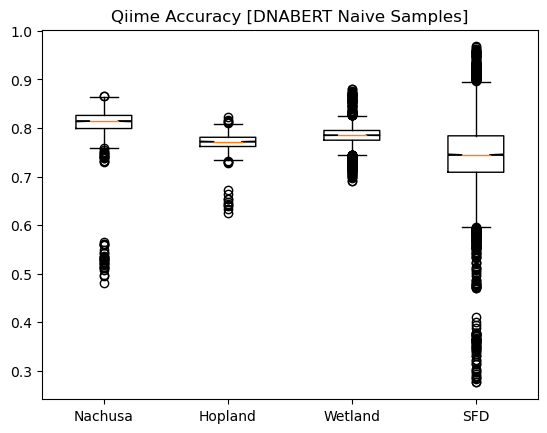

In [44]:
labels = list(dataset_accuracies.keys())
accuracies = list(dataset_accuracies.values())
plt.title("Qiime Accuracy [DNABERT Naive Samples]")
plt.boxplot(accuracies, labels=labels, notch=True)
plt.show()

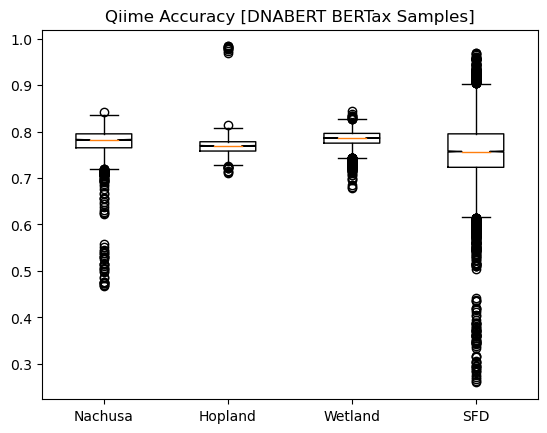

In [54]:
labels = list(dataset_accuracies.keys())
accuracies = list(dataset_accuracies.values())
plt.title("Qiime Accuracy [DNABERT BERTax Samples]")
plt.boxplot(accuracies, labels=labels, notch=True)
plt.show()

In [29]:
accuracies_dnabert_naive = np.loadtxt("./logs/dnabert_taxonomy_naive_accuracy.txt")
accuracies_dnabert_bertax = np.loadtxt("./logs/dnabert_taxonomy_bertax_accuracy.txt")
accuracies_dnabert_topdown = np.loadtxt("./logs/dnabert_taxonomy_topdown_accuracy.txt")
accuracies_setbert = np.loadtxt("./logs/setbert_taxonomy_naive_full_accuracy.txt")

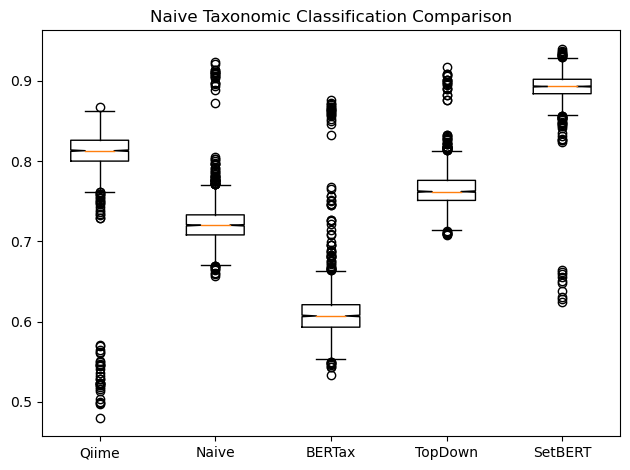

In [34]:
plt.title("Taxonomic Classification Comparison")
plt.boxplot([
    accuracies,
    accuracies_dnabert_naive,
    accuracies_dnabert_bertax,
    accuracies_dnabert_topdown,
    accuracies_setbert], notch=True, labels=["Qiime", "Naive", "BERTax", "TopDown", "SetBERT"])
plt.tight_layout()
plt.show()

In [ ]:
group of 3 models (naive, bertax, topdown) for one dataset


In [ ]:
group: 1 model, 3 different sample types for one dataset

In [ ]:
SFD(naive Sample): Naive/BERTax/Topdown (models)

In [ ]:
SFD(Naive Model): Naive/BERTAx/Topdown (samples)

In [62]:
def load(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [250]:
accuracies = { # [model][sample_type]
    "Qiime": {
        "Naive": load("./logs/qiime_taxonomy_naive_accuracies.txt"),
        "BERTax": load("./logs/qiime_taxonomy_bertax_accuracies.txt"),
        "Topdown": load("./logs/qiime_taxonomy_topdown_accuracies.txt")
    },
    "DNABERT Naive": {
        "Naive": load("./logs/dnabert_taxonomy_naive_naive_accuracies.txt"),
        "BERTax": load("./logs/dnabert_taxonomy_bertax_naive_accuracies.txt"),
        "Topdown": load("./logs/dnabert_taxonomy_topdown_naive_accuracies.txt")
    },
    "DNABERT BERTax": {
        "Naive": load("./logs/dnabert_taxonomy_naive_bertax_accuracies.txt"),
        "BERTax": load("./logs/dnabert_taxonomy_bertax_bertax_accuracies.txt"),
        "Topdown": load("./logs/dnabert_taxonomy_topdown_bertax_accuracies.txt")
    },
    "DNABERT Topdown": {
        "Naive": load("./logs/dnabert_taxonomy_naive_topdown_accuracies.txt"),
        "BERTax": load("./logs/dnabert_taxonomy_bertax_topdown_accuracies.txt"),
        "Topdown": load("./logs/dnabert_taxonomy_topdown_topdown_accuracies.txt")
    },
}

In [251]:
dataset = "SFD"

In [252]:
from itertools import count

In [253]:
def position_gen(group_size: int):
    pos = np.linspace(1, 2, group_size)
    yield pos, np.mean(pos)
    for i in count():
        pos += group_size
        yield pos, np.mean(pos)

In [256]:
# function for setting the colors of the box plots pairs
def set_box_colors(bp):
    plt.setp(bp['boxes'][0], color='blue')
    plt.setp(bp['caps'][0], color='blue')
    plt.setp(bp['caps'][1], color='blue')
    plt.setp(bp['whiskers'][0], color='blue')
    plt.setp(bp['whiskers'][1], color='blue')
    plt.setp(bp['fliers'][0], color='blue')
    plt.setp(bp['medians'][0], color='blue')

    plt.setp(bp['boxes'][1], color='red')
    plt.setp(bp['caps'][2], color='red')
    plt.setp(bp['caps'][3], color='red')
    plt.setp(bp['whiskers'][2], color='red')
    plt.setp(bp['whiskers'][3], color='red')
    plt.setp(bp['fliers'][1], color='red')
    plt.setp(bp['medians'][1], color='red')

    plt.setp(bp['boxes'][2], color='green')
    plt.setp(bp['caps'][4], color='green')
    plt.setp(bp['caps'][5], color='green')
    plt.setp(bp['whiskers'][4], color='green')
    plt.setp(bp['whiskers'][5], color='green')
    plt.setp(bp['fliers'][2], color='green')
    plt.setp(bp['medians'][2], color='green')

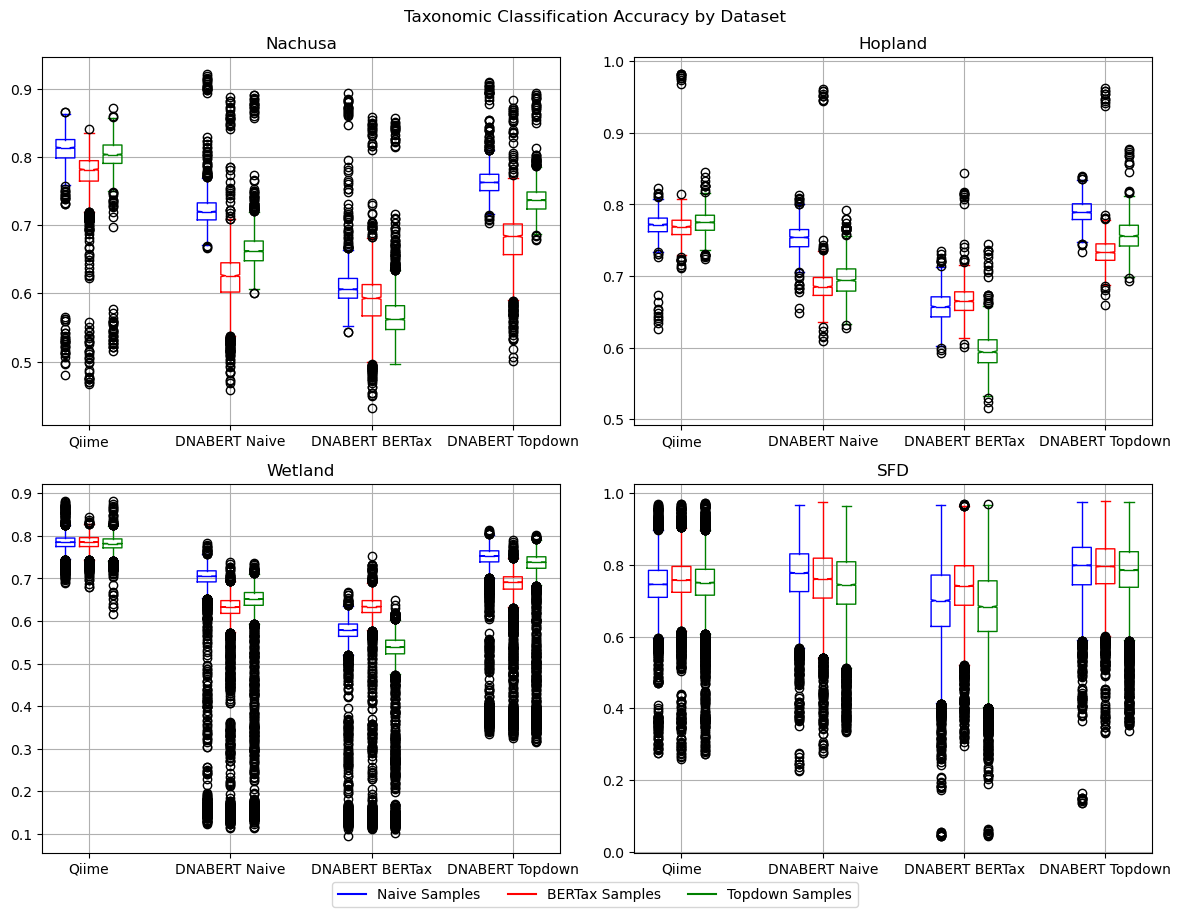

In [257]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
axs = axs.flatten()
group_size = 3
colors = ["blue", "red", "green"]
for dataset, ax in zip(["Nachusa", "Hopland", "Wetland", "SFD"], axs):
    pos_gen = position_gen(group_size)

    xticks = []
    for model in accuracies:
        acc = [sample[dataset] for sample in accuracies[model].values()]
        pos, xtick = next(pos_gen)
        bp = ax.boxplot(acc, positions=pos, widths=2/(2**(group_size-1))*0.8, notch=True)
        set_box_colors(bp)
        xticks.append(xtick)
    for sample, color in zip(accuracies[model], colors):
        ax.plot([], [], color=color, label=f"{sample} Samples")

    ax.set_title(f"{dataset}")
    ax.set_xticks(xticks)
    ax.set_xticklabels(list(accuracies.keys()))
    ax.grid()
handles, labels = ax.get_legend_handles_labels()
fig.suptitle("Taxonomic Classification Accuracy by Dataset")
fig.tight_layout()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.025, 0.0, 0.0), ncol=3)

In [169]:
1: 2
2: 1
3: 0.5

SyntaxError: illegal target for annotation (3059452682.py, line 1)

In [182]:
2/

0.5